In [57]:
import mxnet
from mxnet import np, npx, autograd
from mxnet.gluon import Trainer, nn
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
import mxnet.initializer as initializer
from PIL import Image
from d2l import mxnet as d2l
from pdb import set_trace
npx.set_np()

### Get Data

In [58]:
batch_size = 256
train_dl, test_dl = d2l.load_data_fashion_mnist(batch_size, resize=224)

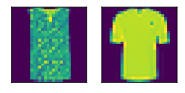

In [56]:
imgs = next(iter(train_dl))
d2l.show_images([img.squeeze() for img in list(imgs[0])], 1, 2);

### Define Architecture

In [70]:
activation = 'relu'
net = nn.Sequential()
net.add(nn.Conv2D(96, 11, 4),
        nn.MaxPool2D(3, 2),
        nn.Conv2D(256, 5, 1, 2),
        nn.MaxPool2D(3, 2),
        nn.Conv2D(384, 3, 1, 1),
        nn.Conv2D(384, 3, 1, 1),
        nn.Conv2D(256, 3, 1, 1),
        nn.MaxPool2D(3, 2),
        nn.Dense(4096, activation='relu'),
        nn.Dropout(0.5),
        nn.Dense(4096, activation='relu'),
        nn.Dropout(0.5),
        nn.Dense(10))
net.initialize(initializer.Xavier(), force_reinit=True)

In [71]:
net

Sequential(
  (0): Conv2D(-1 -> 96, kernel_size=(11, 11), stride=(4, 4))
  (1): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (2): Conv2D(-1 -> 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (4): Conv2D(-1 -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2D(-1 -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): Conv2D(-1 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (8): Dense(-1 -> 4096, Activation(relu))
  (9): Dropout(p = 0.5, axes=())
  (10): Dense(-1 -> 4096, Activation(relu))
  (11): Dropout(p = 0.5, axes=())
  (12): Dense(-1 -> 10, linear)
)

In [69]:
X1orig = X1 = np.random.uniform(size=(1, 1, 224, 224))
for layer in net:
    X1 = layer(X1)
    print(f'{layer.name} shape is {X1.shape}')

conv47 shape is (1, 96, 54, 54)
pool41 shape is (1, 96, 26, 26)
conv48 shape is (1, 256, 26, 26)
pool42 shape is (1, 256, 12, 12)
conv49 shape is (1, 384, 12, 12)
conv50 shape is (1, 384, 12, 12)
conv51 shape is (1, 256, 12, 12)
pool43 shape is (1, 256, 5, 5)
dense57 shape is (1, 4096)
dropout2 shape is (1, 4096)
dense58 shape is (1, 4096)
dropout3 shape is (1, 4096)
dense59 shape is (1, 10)


### Define Loss

In [72]:
def loss_fn(yhat, y):
    lfn = SoftmaxCrossEntropyLoss()
    return lfn(yhat, y)

### Train Network

In [ ]:
num_epochs = 5
lr = 0.1
optim = Trainer(net.collect_params(), 'adam', optimizer_params={'learning_rate': lr})
for epoch in range(num_epochs):
    for X, y in iter(train_dl):
        with autograd.record():
            yhat = net(X)
            loss = loss_fn(yhat, y)
        loss.backward()
        optim.step(batch_size=X.shape[0])
    test_accuracy = calc_accuracy(test_dl, net)
    print(f'Epoch: {epoch}, Loss is: {loss.mean()}, test_accuracy: {test_accuracy}')

### Calculate Accuracy

In [30]:
def calc_accuracy(dl, net):
    num_samples = 0
    num_correct = 0
    for X, y in iter(dl):
        yhat = net(X)
        classes = yhat.argmax(axis=1).astype('int32')
        matches = (classes == y)
        num_samples += X.shape[0]
        num_correct += matches.sum().item()
    return num_correct/num_samples

In [49]:
calc_accuracy(test_dl, net)

0.7872

### Things I learnt
- I had replaced the sigmoid with ReLU. ReLU's are prone to a problem called dead ReLU. This [link](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks) explains the problem in detail. Essentially, a large negative gradient could cause the input activations to always be negative. This would mean that the gradient for the ReLU will always be -ve and it will never recover
- Reducing the LR helped for this case
- The other thing was that Xavier initialization helped gain 3% points of accuracy as compared to Normal(0.01) initialization